# Import

In [3]:
from ray.rllib.examples.policy.rock_paper_scissors_dummies import (
    BeatLastHeuristic,
    AlwaysSameHeuristic,
)
import os
import random
from ray.rllib.policy.policy import PolicySpec
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig
from gymnasium.spaces import Tuple, Discrete, Box,Dict
import ray
from ray import air
from ray import tune
from ray.tune.registry import register_env
from ray.rllib.env.multi_agent_env import MultiAgentEnv
import numpy as np
from ray.rllib.utils import check_env
from typing import Optional
from ray.rllib.algorithms.pg import (
    PG,
    PGConfig,
    PGTF2Policy,
    PGTF1Policy,
    PGTorchPolicy,
)
import argparse
from ray.rllib.utils.test_utils import check_learning_achieved
from ray.rllib.utils.framework import try_import_tf, try_import_torch
from ray.rllib.algorithms.maddpg.maddpg import MADDPGConfig,DQN
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector


In [33]:
import numpy as np
l = [1,1,1]
print(np.stack([True,True,False]).dtype)
print(np.ndarray(shape=(len(l)),buffer=np.array(l),dtype=np.int))

bool
[1 1 1]


/tmp/ipykernel_9957/2774214198.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(np.ndarray(shape=(len(l)),buffer=np.array(l),dtype=np.int))


In [4]:
er = [345, 249, 30, 30, 102, 168, 135, 306, 294, 45, 39, 57, 51, 42, 60, 30, 81, 534, 426, 348, 180, 201, 54, 69, 39, 30, 30, 903, 30, 111, 453, 30, 30, 117, 366, 339, 30, 30, 192, 99, 30, 363, 72, 393, 222, 30, 678, 36, 30, 30, 42, 624, 36, 108, 75, 30, 201, 30, 513, 60, 63, 63, 39, 30, 39, 318, 30, 30, 78, 165, 390, 102, 108, 294, 45, 54, 30, 249, 282, 639, 42, 348, 126, 348, 81, 501, 48, 318, 663]
el = [45, 29, 3, 3, 17, 29, 23, 33, 39, 9, 5, 11, 9, 7, 9, 1, 13, 45, 45, 39, 33, 27, 9, 17, 7, 3, 3, 67, 7, 21, 45, 1, 1, 21, 41, 40, 1, 3, 33, 17, 3, 51, 15, 43, 43, 3, 71, 5, 5, 7, 9, 55, 7, 21, 15, 3, 33, 3, 59, 9, 15, 11, 7, 1, 5, 37, 5, 1, 15, 25, 47, 19, 23, 41, 7, 17, 1, 37, 37, 59, 9, 45, 21, 49, 17, 45, 7, 41, 69]
print(len(er))
print(len(el))

([345, 249, 30, 30, 102, 168, 135, 306, 294, 45, 39, 57, 51, 42, 60, 30, 81, 534, 426, 348, 180, 201, 54, 69, 39, 30, 30, 903, 30, 111, 453, 30, 30, 117, 366, 339, 30, 30, 192, 99, 30, 363, 72, 393, 222, 30, 678, 36, 30, 30, 42, 624, 36, 108, 75, 30, 201, 30, 513, 60, 63, 63, 39, 30, 39, 318, 30, 30, 78, 165, 390, 102, 108, 294, 45, 54, 30, 249, 282, 639, 42, 348, 126, 348, 81, 501, 48, 318, 663],)


43
43


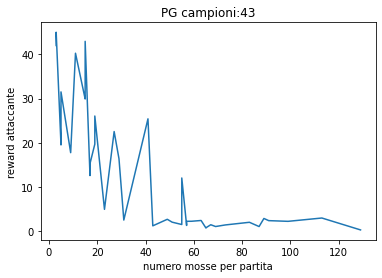

43
43


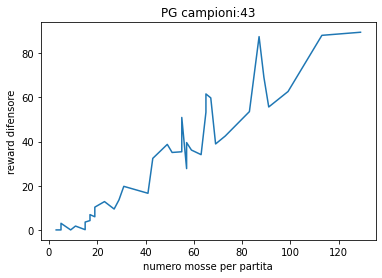

In [25]:
import matplotlib.pyplot as plt
d = {'attaccante': [(3, 45.0), (55, 2.3786688233619255), (15, 29.892857142857142), (5, 22.5), (65, 0.755600649350649), (49, 2.674019607843137), (55, 1.492533696094068), (3, 42.0), (55, 12.02097829071514), (91, 2.369148212898213), (73, 1.3937010133941075), (15, 42.94285714285714), (57, 1.2803030303030303), (15, 30.392857142857142), (23, 4.923160173160173), (51, 2.0258373205741624), (87, 1.0329863934515089), (65, 0.7019866003561601), (17, 12.567857142857143), (55, 2.7753357753357752), (5, 31.5), (43, 1.1934523809523805), (83, 1.996322293358936), (67, 1.4420120320855618), (11, 40.25), (27, 22.528846153846153), (9, 17.75), (19, 26.041666666666668), (89, 2.8595571095571084), (3, 45.0), (57, 2.221229126835533), (19, 19.68452380952381), (31, 2.5), (41, 25.40384615384615), (29, 16.391941391941394), (59, 2.2261706079764148), (17, 15.267857142857142), (113, 2.9631832669127056), (99, 2.212057367949009), (129, 0.26972397129846515), (5, 19.5), (69, 1.0374211757039096), (63, 2.4039852737258074)], 'difensore': [(3, 0), (55, 50.944408099715), (15, 0.1071428571428572), (5, 0), (65, 53.333605305984335), (49, 38.738741544048445), (55, 35.40746630390593), (3, 0), (55, 36.479021709284865), (91, 55.689810158640384), (73, 42.53983873314968), (15, 3.5571428571428574), (57, 39.564935064935064), (15, 1.1071428571428572), (23, 12.826839826839828), (51, 35.08585735729698), (87, 87.55584531457184), (65, 61.5891424319019), (17, 6.932142857142857), (55, 38.57249031162075), (5, 3.0), (43, 32.41707393483709), (83, 53.59827230123566), (67, 59.81123459021732), (11, 1.75), (27, 9.471153846153847), (9, 0.0), (19, 5.958333333333333), (89, 69.12591653158043), (3, 0), (57, 27.778770873164465), (19, 10.315476190476192), (31, 19.73901098901099), (41, 16.596153846153847), (29, 13.60805860805861), (59, 36.17382939202358), (17, 4.232142857142858), (113, 88.14320829159757), (99, 62.70338469800344), (129, 89.5452472826189), (5, 0), (69, 38.94533744498575), (63, 34.0960147262742)]}

a = d['attaccante']
x = []
y = []
a.sort()
for i in a :
    x.append(i[0])
    y.append(i[1])
print(len(x))
print(len(y))
plt.title('PG campioni:'+str(len(x)))
plt.ylabel('reward attaccante')
plt.xlabel('numero mosse per partita')
plt.plot(x,y)
plt.show()

x = []
y = []
b = d['difensore']
b.sort()
for i in b :
    x.append(i[0])
    y.append(i[1])
print(len(x))
print(len(y))
plt.title('PG campioni:'+str(len(x)))
plt.ylabel('reward difensore')
plt.xlabel('numero mosse per partita')
plt.plot(x,y)
plt.show()

[(3, 42.0), (3, 42.0), (3, 42.0), (3, 42.0), (3, 45.0), (3, 45.0), (5, 22.5), (5, 22.5), (5, 34.5), (5, 34.5), (5, 46.5), (5, 49.5), (5, 49.5), (5, 49.5), (7, 17.0), (7, 21.5), (7, 21.5), (7, 23.0), (7, 26.0), (7, 30.5), (7, 48.5), (9, 11.75), (9, 20.75), (9, 28.25), (9, 30.75), (9, 32.25), (9, 49.25), (9, 50.25), (11, 5.75), (11, 20.25), (11, 27.75), (11, 32.0), (11, 35.75), (11, 39.75), (11, 44.25), (13, 8.5), (13, 11.5), (13, 32.25), (13, 39.25), (15, 5.142857142857142), (15, 13.642857142857142), (15, 21.192857142857143), (15, 21.892857142857142), (15, 23.892857142857142), (15, 33.892857142857146), (15, 36.642857142857146), (17, 7.767857142857142), (17, 12.017857142857142), (17, 21.375), (17, 22.875), (17, 24.875), (17, 33.625), (19, 3.666666666666667), (19, 16.291666666666668), (19, 18.541666666666668), (19, 22.291666666666668), (19, 24.43452380952381), (19, 24.80952380952381), (19, 25.541666666666668), (19, 32.791666666666664), (21, 23.416666666666668), (23, 6.806493506493506), (2

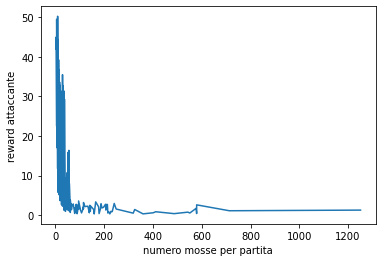

208
208


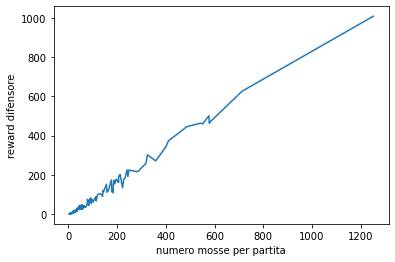

In [23]:
import matplotlib.pyplot as plt
d ={'attaccante': [(37, 26.315960999784526), (61, 0.6823529411764704), (47, 1.9690506637437584), (25, 2.6428571428571423), (57, 2.3333142639206743), (13, 39.25), (11, 5.75), (197, 1.9759779374899744), (67, 1.8516302776171187), (15, 23.892857142857142), (41, 8.006493506493506), (31, 8.214285714285714), (55, 1.9953823953823948), (9, 28.25), (19, 3.666666666666667), (9, 20.75), (7, 26.0), (15, 5.142857142857142), (53, 1.2557045895281185), (7, 30.5), (19, 32.791666666666664), (37, 16.25), (31, 32.744588744588754), (33, 21.7092032967033), (19, 25.541666666666668), (3, 45.0), (87, 0.8443974681453189), (17, 7.767857142857142), (27, 14.267482517482517), (5, 49.5), (11, 39.75), (31, 15.696428571428571), (55, 16.380230880230886), (29, 3.2555777555777556), (107, 0.5679815616495514), (39, 9.417449874686717), (5, 46.5), (15, 21.192857142857143), (89, 0.3619098687156766), (139, 0.5909055567865117), (37, 13.474614845938378), (79, 1.810889682213215), (11, 32.0), (7, 21.5), (9, 11.75), (19, 16.291666666666668), (43, 1.8755411255411247), (9, 50.25), (7, 23.0), (45, 1.877299783549783), (11, 27.75), (17, 33.625), (41, 1.5394736842105263), (21, 23.416666666666668), (5, 22.5), (113, 1.5625905797101445), (27, 6.903846153846153), (5, 34.5), (13, 32.25), (85, 1.7244137441505873), (15, 21.892857142857142), (17, 12.017857142857142), (165, 3.3581514736923848), (47, 1.6619078066009012), (17, 21.375), (3, 42.0), (61, 2.6156968031968026), (7, 21.5), (3, 42.0), (19, 24.80952380952381), (27, 23.703846153846154), (67, 1.5812425873503964), (15, 13.642857142857142), (49, 1.380357142857143), (49, 2.061206696117182), (115, 1.5998769092590666), (29, 2.2847985347985347), (3, 42.0), (27, 28.3984348984349), (27, 28.070512820512818), (27, 23.892482517482517), (57, 2.4965728715728708), (61, 0.7719719428644436), (11, 20.25), (57, 1.0197988286223572), (207, 2.688413591863905), (11, 35.75), (17, 24.875), (35, 1.2633053221288506), (37, 14.682032428355958), (49, 3.4529220779220777), (31, 14.839285714285714), (59, 4.634182771251737), (17, 22.875), (95, 3.5866829260507527), (33, 14.729166666666668), (83, 0.8414987672118849), (39, 2.0051599587203306), (37, 7.609744422244421), (9, 30.75), (19, 18.541666666666668), (113, 2.0288813353828887), (5, 34.5), (19, 22.291666666666668), (29, 23.071428571428573), (87, 1.0780565786426615), (5, 22.5), (57, 8.019761150367556), (33, 22.37256493506494), (7, 17.0), (27, 31.346703296703296), (227, 0.7700507322773062), (41, 0.9529220779220795), (141, 2.493086289533253), (27, 24.528846153846153), (9, 49.25), (139, 1.1124800433004332), (33, 9.961309523809526), (15, 33.892857142857146), (177, 2.114232354658851), (93, 2.638569929382136), (37, 29.30134644766998), (57, 1.4395604395604393), (27, 14.059149184149184), (15, 36.642857142857146), (13, 11.5), (219, 0.86288586881285), (121, 2.1653997202956594), (185, 1.6760484775921511), (53, 1.2497657819588752), (37, 2.630036630036629), (77, 1.3815375414059625), (39, 7.140664160401002), (19, 24.43452380952381), (25, 17.192857142857143), (179, 0.397053299181788), (85, 2.75466505353993), (41, 1.9144736842105265), (115, 3.1968633417250216), (63, 2.914967648838616), (63, 2.416132118109496), (233, 0.9096940113582034), (5, 49.5), (23, 6.806493506493506), (61, 3.8323429444119097), (9, 32.25), (3, 45.0), (91, 1.056159880092807), (5, 49.5), (37, 20.708818142641675), (69, 2.491090837622167), (103, 1.2701505918932308), (29, 16.736638361638363), (13, 8.5), (157, 1.4087518255037461), (65, 1.346947013997918), (325, 1.4332323634179525), (43, 2.3641211729447056), (47, 1.9795548654244302), (43, 2.9642857142857135), (37, 23.26747198879552), (551, 0.5397638860544971), (23, 30.488636363636363), (145, 2.2745360615779284), (223, 0.32738943258512687), (249, 1.5481183314183524), (51, 2.718506493506493), (205, 2.734958610661314), (73, 2.8219662058371724), (577, 1.728830392611192), (241, 2.964924286214072), (3, 42.0), (11, 44.25), (35, 31.36655623787977), (187, 2.886846582419381), (57, 2.700614504174875), (95, 1.4628145333961813), (207, 1.282667110774193), (185, 1.8238314238859168), (713, 1.1157995832365668), (53, 1.2950742111345874), (245, 2.2419212427518582), (95, 1.889064578192118), (215, 0.5445501793112729), (29, 35.49313186813187), (79, 0.42999428886525776), (133, 2.277096233259828), (27, 4.796703296703296), (143, 0.9823328729044953), (401, 0.603574597167801), (159, 0.315384653173869), (7, 48.5), (227, 0.9601434771364713), (213, 2.700509222216803), (543, 0.760775186504971), (411, 0.86401585274501), (33, 18.889506327006327), (579, 0.404429894502865), (45, 9.398287664348036), (51, 15.851671122994654), (487, 0.3844853071530055), (191, 1.8303149097215254), (579, 2.606024104801253), (359, 0.3291024318289222), (1251, 1.2771138679676133), (47, 10.687426818033222), (285, 1.010989268256513), (319, 0.507344847081611)], 'difensore': [(37, 20.184039000215474), (61, 34.96255106785797), (47, 26.408142318712382), (25, 9.357142857142858), (57, 43.01113018052377), (13, 2.75), (11, 0.25), (197, 177.9571015590894), (67, 39.08274124629834), (15, 6.107142857142858), (41, 21.993506493506494), (31, 11.285714285714286), (55, 33.44779942279942), (9, 1.75), (19, 2.333333333333333), (9, 2.25), (7, 4.0), (15, 5.357142857142858), (53, 36.764437110876734), (7, 4.5), (19, 9.208333333333334), (37, 13.749999999999998), (31, 9.255411255411255), (33, 20.290796703296703), (19, 4.458333333333333), (3, 0), (87, 60.26790411915627), (17, 7.232142857142858), (27, 15.732517482517483), (5, 0), (11, 2.25), (31, 19.303571428571427), (55, 25.619769119769117), (29, 7.244422244422244), (107, 75.672958125262), (39, 25.582550125313283), (5, 0), (15, 1.0571428571428574), (89, 64.03868709214788), (139, 93.72492026980592), (37, 21.025385154061624), (79, 57.720360317786785), (11, 1.0), (7, 0), (9, 0), (19, 13.708333333333334), (43, 30.374458874458877), (9, 0.0), (7, 0.0), (45, 28.122700216450216), (11, 2.25), (17, 4.625), (41, 23.49484004127967), (21, 6.583333333333332), (5, 0), (113, 87.46984195278107), (27, 12.596153846153847), (5, 0.0), (13, 2.25), (85, 42.858919589182754), (15, 0.5), (17, 4.982142857142858), (165, 119.51513123877677), (47, 34.33809219339909), (17, 8.625), (3, 0), (61, 38.902350880114035), (7, 0), (3, 0), (19, 5.190476190476191), (27, 12.796153846153846), (67, 32.918757412649605), (15, 1.3571428571428572), (49, 35.243769849076756), (49, 27.188793303882818), (115, 66.15575109636896), (29, 8.465201465201465), (3, 0), (27, 13.601565101565104), (27, 13.929487179487179), (27, 18.107517482517483), (57, 47.60347403378094), (61, 41.22802805713556), (11, 2.25), (57, 46.69303447334138), (207, 190.68666620648372), (11, 1.75), (17, 5.125), (35, 25.30162974280621), (37, 19.817967571644044), (49, 43.575618943749745), (31, 19.660714285714285), (59, 25.365817228748263), (17, 7.125), (95, 52.746208820849716), (33, 19.770833333333336), (83, 44.158501232788126), (39, 24.828173374613005), (37, 22.39025557775558), (9, 3.0), (19, 11.458333333333334), (113, 85.25925038291935), (5, 0.0), (19, 14.208333333333334), (29, 11.428571428571429), (87, 72.92202135375233), (5, 0), (57, 38.48023884963244), (33, 19.627435064935064), (7, 3.0), (27, 10.653296703296704), (227, 170.90736715085526), (41, 33.54707792207792), (141, 89.92900821996729), (27, 14.971153846153847), (9, 0), (139, 93.75385346199971), (33, 20.038690476190478), (15, 0.6071428571428572), (177, 173.5321978095937), (93, 60.73116450285229), (37, 17.198653552330025), (57, 22.549674010200324), (27, 15.940850815850816), (15, 7.357142857142858), (13, 3.5), (219, 161.31815569193742), (121, 99.60432111611726), (185, 108.07771744187215), (53, 41.50023421804112), (37, 20.4876104287869), (77, 48.34437409954775), (39, 22.859335839598998), (19, 6.315476190476191), (25, 12.807142857142857), (179, 112.89345221760622), (85, 46.9931610334166), (41, 32.24715635241951), (115, 69.70694478449452), (63, 35.567790971851046), (63, 40.06662650258017), (233, 181.9208534587665), (5, 0), (23, 10.193506493506494), (61, 41.917657055588094), (9, 2.25), (3, 0), (91, 80.83564863777319), (5, 0), (37, 28.54118185735833), (69, 32.50890916237783), (103, 60.382230360487725), (29, 17.763361638361637), (13, 6.5), (157, 151.45551504102235), (65, 41.55305298600207), (325, 301.6151089262575), (43, 39.63587882705529), (47, 27.617258860065768), (43, 34.6062965994274), (37, 23.23252801120448), (551, 459.1868978819626), (23, 16.011363636363637), (145, 113.81357620194767), (223, 133.57587984754085), (249, 223.85957413517707), (51, 32.422853694293316), (205, 161.34232179907622), (73, 36.571506700566765), (577, 500.8964264262504), (241, 224.79229761823797), (3, 0), (11, 2.25), (35, 17.883443762120233), (187, 172.2191145299277), (57, 42.64382994026957), (95, 78.52133653325704), (207, 161.3757352164142), (185, 146.18769476817192), (713, 626.1585513853439), (53, 40.70492578886541), (245, 191.1650349401323), (95, 57.14501058998315), (215, 186.36901007537907), (29, 11.006868131868133), (79, 74.47009785325474), (133, 102.98897135697251), (27, 10.953296703296704), (143, 120.01111418400637), (401, 343.53190296774574), (159, 110.59621767322207), (7, 0), (227, 176.3152714458388), (213, 202.25294777334992), (543, 463.08273393844075), (411, 372.7806660958023), (33, 15.610493672993677), (579, 462.353458926686), (45, 32.60171233565197), (51, 26.148328877005344), (487, 445.6345028473175), (191, 153.14941047754021), (579, 466.2506005570176), (359, 270.73188725848286), (1251, 1008.8536611891917), (47, 23.812573181966773), (285, 215.17243717242727), (319, 258.61517403898404)]}

a = d['attaccante']
x = []
y = []
a.sort()
for i in a :
    x.append(i[0])
    y.append(i[1])
print(len(x))
print(len(y))
plt.title('PG campioni:'+str(len(x)))
plt.ylabel('reward attaccante')
plt.xlabel('numero mosse per partita')
plt.plot(x,y)
plt.show()

x = []
y = []
b = d['difensore']
b.sort()
for i in b :
    x.append(i[0])
    y.append(i[1])
print(len(x))
print(len(y))
plt.title('PG campioni:'+str(len(x)))
plt.ylabel('reward difensore')
plt.xlabel('numero mosse per partita')
plt.plot(x,y)
plt.show()